## Function Def

In [44]:
from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm  # ✅ 진행률 표시
import glob
import json


vector.register_awkward()




def overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return target[mask]

def toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False,events=None):
    toptagging = events["FatJet_particleNetWithMass_TvsQCD"].array()
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return toptagging[mask]

def sdm_toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False,events=None):
    softdrop_mass = events["FatJet_msoftdrop"].array()
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return softdrop_mass[mask]

def btagging_overlap_removal(target, cleans, cut=0.4, dphi=False,events=None):
    btagging = events["FatJet_btagDeepB"].array()
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return btagging[mask]

def overlap_itself_removal(target, cleans, cut=0.4, dphi=False):
            mask = ak.ones_like(target["pt"], dtype=bool)
            for clean in cleans:
                pairs = ak.cartesian([target, clean], nested=True) # axis 0 = #event , axis 1 = target , axis 2 = clean
                delta = np.abs(pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
                mask = mask & (ak.min(delta, axis=2) > cut)
            return target[mask]
def find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return jets[closest_idx_per_obj]
def btag_find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return btagging[closest_idx_per_obj]
def Select(inputcoll,etamax,ptmin) :
    output = []
    for obj in inputcoll :
        if abs(obj["eta"]) < etamax and obj["pt"] > ptmin : output.append(obj)
    return output 
def btag4_overlap_removal(target, cleans, cut=0.4, dphi=False,events=None):
    btag = events["Jet_btagPNetB"].array()
    #btag = events["Jet_btagDeepFlavB"].array()
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return btag[mask]

def ak8ak4(sample):


    file = uproot.open(sample)
    events = file["Events"]
    vector.register_awkward()
    keys = events.keys()
    # LHE-level
    lhe_pdgid = events["LHEPart_pdgId"].array()
    lhe_pt     = events["LHEPart_pt"].array()
    lhe_eta    = events["LHEPart_eta"].array()
    lhe_phi    = events["LHEPart_phi"].array()
    lhe_mass   = events["LHEPart_mass"].array()

    bottom_mask   = (lhe_pdgid == 5) | (lhe_pdgid == -5)
    lhe_muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13)

    lhe_particle = ak.zip({
        "pt":   lhe_pt,
        "eta":  lhe_eta,
        "phi":  lhe_phi,
        "mass": lhe_mass
    }, with_name="Momentum4D")

    lhe_bottoms      = lhe_particle[bottom_mask]
    lhe_bottoms_eta  = lhe_bottoms["eta"][:, 1:2]
    lhe_bottoms_phi  = lhe_bottoms["phi"][:, 1:2]
    lhe_bottoms_pt   = lhe_bottoms["pt"][:, 1:2]
    lhe_bottoms_mass = lhe_bottoms["mass"][:, 1:2]

    lhe_bottom2_eta  = lhe_bottoms["eta"][:, 0:1]
    lhe_bottom2_phi  = lhe_bottoms["phi"][:, 0:1]
    lhe_bottom2_pt   = lhe_bottoms["pt"][:, 0:1]
    lhe_bottom2_mass = lhe_bottoms["mass"][:, 0:1]

    lhe_bottom = ak.zip({
        "pt":   lhe_bottoms_pt,
        "eta":  lhe_bottoms_eta,
        "phi":  lhe_bottoms_phi,
        "mass": lhe_bottoms_mass
    }, with_name="Momentum4D")

    lhe_bottom2 = ak.zip({
        "pt":   lhe_bottom2_pt,
        "eta":  lhe_bottom2_eta,
        "phi":  lhe_bottom2_phi,
        "mass": lhe_bottom2_mass
    }, with_name="Momentum4D")

    # LHE muons
    lhe_muons = lhe_particle[lhe_muon_mask]
    n_mother_muon = ak.zip({
        "pt":   lhe_muons["pt"][:, 0:1],
        "eta":  lhe_muons["eta"][:, 0:1],
        "phi":  lhe_muons["phi"][:, 0:1],
        "mass": lhe_muons["mass"][:, 0:1]
    }, with_name="Momentum4D")
    wr_mother_muon = ak.zip({
        "pt":   lhe_muons["pt"][:, 1:2],
        "eta":  lhe_muons["eta"][:, 1:2],
        "phi":  lhe_muons["phi"][:, 1:2],
        "mass": lhe_muons["mass"][:, 1:2]
    }, with_name="Momentum4D")

    # Gen-level top
    gen_pids   = events["GenPart_pdgId"].array()
    genparticle = ak.zip({
        "pt":   events["GenPart_pt"].array(),
        "eta":  events["GenPart_eta"].array(),
        "phi":  events["GenPart_phi"].array(),
        "mass": events["GenPart_mass"].array()
    }, with_name="Momentum4D")
    gentops = genparticle[(gen_pids == 6) | (gen_pids == -6)]
    gentop = ak.zip({
        "pt":   gentops["pt"][:, 0:1],
        "eta":  gentops["eta"][:, 0:1],
        "phi":  gentops["phi"][:, 0:1],
        "mass": gentops["mass"][:, 0:1]
    }, with_name="Momentum4D")

    # Reco-level
    ak4_eta = events["Jet_eta"].array()
    ak4_phi = events["Jet_phi"].array()
    ak4_pt = events["Jet_pt"].array()
    ak4_flavor = events["Jet_hadronFlavour"].array()
    ak4_mass = events["Jet_mass"].array()
    btag = events["Jet_btagPNetB"].array()

    ak4 = ak.zip({
        "pt": ak4_pt,
        "eta": ak4_eta,
        "phi": ak4_phi,
        "mass": ak4_mass
        }, with_name = "Momentum4D")
    
    fatjets = ak.zip({
        "pt":   events["FatJet_pt"].array(),
        "eta":  events["FatJet_eta"].array(),
        "phi":  events["FatJet_phi"].array(),
        "mass": events["FatJet_mass"].array()
    }, with_name="Momentum4D")
    reco_muons = ak.zip({
        "pt":   events["Muon_pt"].array(),
        "eta":  events["Muon_eta"].array(),
        "phi":  events["Muon_phi"].array(),
        "mass": events["Muon_mass"].array()
    }, with_name="Momentum4D")
    btagging = events["FatJet_btagDeepB"].array()
    toptagging = events["FatJet_particleNetWithMass_TvsQCD"].array()
    softdrop_mass = events["FatJet_msoftdrop"].array()
    btag = events["Jet_btagPNetB"].array()
    # Clean b-jet
    
    first_muon = reco_muons[:, 0:1]  # 첫 번째 뮤온
    second_muon = reco_muons[:, 1:2]  # 두 번째 뮤온
    sortidx = ak.argsort(-reco_muons["pt"], axis=1)  # pt 기준으로 내림차순 정렬
    first_muon = reco_muons[sortidx][:, 0:1]  # 가장 큰 pt를 가진 뮤온
    second_muon = reco_muons[sortidx][:, 1:2]  # 두 번째로 큰 pt를 가진 뮤온


    muon_iso = events["Muon_tkRelIso"].array() 
    muon_highpt_id = events["Muon_highPtId"].array()

    leading_muon_iso = muon_iso[sortidx][:, 0:1]
    leading_muon_hpt = muon_highpt_id[sortidx][:, 0:1]
    subleading_muon_iso = muon_iso[sortidx][:, 1:2]
    subleading_muon_hpt = muon_highpt_id[sortidx][:, 1:2]

    first_muon_cleaned  = overlap_removal(first_muon, [reco_muons], cut=0.4)
    second_muon_cleaned = overlap_removal(second_muon, [reco_muons], cut=0.4)

    # Clean top-jet
    toptag_scores    = toptagging_overlap_removal(fatjets, [first_muon_cleaned, second_muon_cleaned,fatjets], cut=0.8,events=events)
    softdrop_masses  = sdm_toptagging_overlap_removal(fatjets, [first_muon_cleaned, second_muon_cleaned,fatjets], cut=0.8, events=events)
    signaltop_cleaned = overlap_removal(fatjets, [first_muon_cleaned, second_muon_cleaned, fatjets], cut=0.8)
    mask_top         = (toptag_scores > 0.9) & (softdrop_masses > 120) & (softdrop_masses < 250)
    top_jets         = signaltop_cleaned[mask_top]
    leading_toptag_ak8 = top_jets[ak.argsort(-top_jets["pt"], axis=1)][:, 0:1]

    signalb_cleaned = overlap_removal(ak4, [first_muon_cleaned,second_muon_cleaned,leading_toptag_ak8, ak4], cut=0.4)
    btaggedb_cleaned = btag4_overlap_removal(ak4, [first_muon_cleaned,second_muon_cleaned, leading_toptag_ak8,ak4], cut=0.4, events=events)


    sortidx = ak.argsort(-signalb_cleaned["pt"], axis=1)  # pt 기준으로 내림차순 정렬
    signalb_cleaend_sorted = signalb_cleaned[sortidx][:, 0:1]  # 가장 큰 pt를 가진 jet만 선택
    sorted_btaggedb_cleaned = btaggedb_cleaned[sortidx][:, 0:1]  # 가장 큰 pt를 가진 jet에 대한 b-tag 정보 선택
    #sorted_btaggedb_cleaned2 = btaggedb_cleaned[sortidx][:, 1:2]  # 가장 큰 pt를 가진 jet에 대한 b-tag 정보 선택


    btagging = sorted_btaggedb_cleaned > 0.6734 # particle net
    #btagging = sorted_btaggedb_cleaned > 0.7183 # deepjet
    leading_tagged_bjet = signalb_cleaend_sorted[btagging]
    #sortidx = ak.argsort(-signalb_cleaend_sorted["pt"], axis=1)  # pt 기준으로 내림차순 정렬
    #leading_tagged_bjet = signalb_cleaend_sorted[sortidx][:, 0:1]  # 가장 큰 pt를 가진 jet만 선택

    

    # Event-level mask
    pt1 = ak.sum(first_muon_cleaned["pt"], axis=1)
    pt2 = ak.sum(second_muon_cleaned["pt"], axis=1)
    ptb = ak.sum(leading_tagged_bjet["pt"], axis=1)
    ptt = ak.sum(leading_toptag_ak8["pt"], axis=1)
    eta1 =ak.sum(first_muon_cleaned["eta"], axis=1)
    eta2 = ak.sum(second_muon_cleaned["eta"], axis=1)

    hlt = events["HLT_IsoMu30"].array()
    evt_mask = (
        (pt1 > 0) & (pt2 > 0) &
        (ptb > 0) & (ptt > 0) 
    )

    hlt_mask = (
        (pt1 > 0) & (pt2 > 0) &
        (ptb > 0) & (ptt > 0) & (hlt==True)
    )
    lmi = leading_muon_iso[evt_mask]
    lmhpt = leading_muon_hpt[evt_mask]
    slmi = subleading_muon_iso[evt_mask]
    slhpt = subleading_muon_hpt[evt_mask]

    fm1 = first_muon_cleaned[evt_mask]
    fm2 = second_muon_cleaned[evt_mask]
    lb  = leading_tagged_bjet[evt_mask]
    lt  = leading_toptag_ak8[evt_mask]
    
    # Dilepton mass cut
    mll = (fm1 + fm2).mass
    mll_mask = mll > 0
    fm1 = fm1[mll_mask]
    fm2 = fm2[mll_mask]
    lb  = lb[mll_mask]
    lt  = lt[mll_mask]

    # Final vars
    combined_p4   = (fm1 + fm2 + lb + lt).mass
    mN            = (fm1 + lb + lt).mass
    mu1_pt_flat   = ak.flatten(fm1["pt"])
    mu2_pt_flat   = ak.flatten(fm2["pt"])
    mll_flat      = ak.flatten(mll)
    lt_flat       = ak.flatten(lt["pt"])
    lb_flat       = ak.flatten(lb["pt"])
    totalev       = len(lhe_pt)
    leftev        = len(combined_p4)
    
    hltpassev     = len(ak.flatten(first_muon_cleaned["pt"][hlt_mask]))


    return combined_p4, mN, mu1_pt_flat, mu2_pt_flat,lt_flat,lb_flat, mll_flat ,lmi , slmi, lmhpt, slhpt ,totalev , leftev ,hltpassev , sorted_btaggedb_cleaned

def iter_allfile (path):
    from importlib import import_module
    import os
    import sys
    import argparse
    import linecache
    import uproot
    import vector
    import math
    import numpy as np
    import matplotlib.pyplot as plt
    import awkward as ak
    from tqdm import tqdm  # ✅ 진행률 표시
    import glob
    
    file_list = sorted(glob.glob(path + "*.root"))
    
    combined_p4_list = []
    mll_list = []
    lb_list = []
    lt_list = []
    mu1_pt_list = []
    mu2_pt_list = []
    lmi_list = []
    lmh_list = []
    smi_list = []
    smh_list = []
    btag_list = []
    totalev_list = 0
    leftev_list = 0
    hltpassev_list = 0

    # tqdm으로 파일 리스트 순회
    for sample in tqdm(file_list, desc="Processing ROOT files"):

        combined_p4, mN, mu1_pt, mu2_pt,lt,lb, mll,lmi,lmh,smi,smh,totalev , leftev ,hltpassev, sorted_btaggedb_cleaned = ak8ak4(sample)

        combined_p4_list.append(combined_p4)
        mll_list.append(mll)
        mu1_pt_list.append(mu1_pt)
        mu2_pt_list.append(mu2_pt)
        btag_list.append(sorted_btaggedb_cleaned)
        lt_list.append(lt)
        lb_list.append(lb)
        totalev_list += totalev
        leftev_list += leftev
        hltpassev_list += hltpassev
        lmi_list.append(lmi)
        lmh_list.append(lmh)
        smi_list.append(smi)
        smh_list.append(smh)
    return (combined_p4_list, mll_list, mu1_pt_list, mu2_pt_list,lt_list,lb_list, lmi_list, lmh_list, smi_list, smh_list, btag_list,totalev_list, leftev_list, hltpassev_list)
            # 0. combined_p4_list
            # 1. mll_list
            # 2. mu1_pt_list
            # 3. mu2_pt_list
            # 4. lt_list
            # 5. lb_list
            # 6. lmi_list
            # 7. lmh_list
            # 8. smi_list
            # 9. smh_list
            # 10. btag_list
            # 11. totalev_list
            # 12. leftev_list
            # 13. hltpassev_list


import os
import json

def compute_expected_events(sample_info, iter_allfile, lumi_fb):
    """
    sample_info: dict, 최소 다음 키를 가져야 합니다.
      - "xsec": float    # cross section [pb]
      - "sumW": float    # genEventSumw
      - "path": str OR list[str]
           * str: 디렉터리 경로 (끝에 / 까지 포함)
           * list: 파일 경로 리스트

    iter_allfile: function(path_or_dir)
      # 원래 사용하시던 대로, str을 넘기면 그 경로(또는 디렉터리)에서
      # glob 혹은 자체 로직으로 Events를 읽어서 통과 이벤트 개수를 return

    lumi_fb: float, 분석 luminosity [fb^-1]

    return: dict {
      "Npass": int,    # iter_allfile 결과
      "w_evt": float,  # per-event weight
      "Nexp": float    # 기대 이벤트 수
    }
    """
    p = sample_info["path"]
    # 1) iter_allfile에 넘길 인자 결정
    if isinstance(p, list):
        # 리스트가 주어지면, 첫 번째 엔트리의 디렉터리만 뽑아서 넘김
        first = p[0]
        base_dir = os.path.dirname(first) + os.sep
        Npass = iter_allfile(base_dir)
        mwr = Npass[0]
        mll = Npass[1]
        ptmu1 = Npass[2]
        ptmu2 = Npass[3]
        ptt = Npass[4]
        ptb = Npass[5]
        Npass = (Npass[13])
        
    elif isinstance(p, str):
        # 문자열이 디렉터리인지 파일인지 상관없이 그대로 넘김
        Npass = iter_allfile(p)
        mwr = Npass[0]
        mll = Npass[1]
        ptmu1 = Npass[2]
        ptmu2 = Npass[3]
        ptt = Npass[4]
        ptb = Npass[5]
        Npass = (Npass[13])
    else:

        raise ValueError(f"Unexpected type for sample_info['path']: {type(p)}")

    # 2) per-event normalization weight 계산 (pb→fb 변환 위해 *1000)
    xsec_pb = sample_info["xsec"]
    sumW    = sample_info["sumW"]
    w_evt   = xsec_pb * 1000 * lumi_fb / sumW

    # 3) 기대 이벤트 수
    Nexp = Npass * w_evt

    return {"Npass": Npass, "w_evt": w_evt, "Nexp": Nexp,"WRmass": mwr, "mll": mll, "ptmu1": ptmu1, "ptmu2": ptmu2, "ptt": ptt, "ptb": ptb}




In [3]:
## main back  = ttH , ttZ , ttW , ttbar , tzj

signal1070 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-1000_MN-700_13p6TeV/"
xsec1070 = 194.6 #fb 
signal3013 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-3000_MN-1300_13p6TeV/"
xsec3013 = 1.826
signal3021 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-3000_MN-2100_13p6TeV/"
xsec3021 =  0.9088
signal3029 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-3000_MN-2900_13p6TeV/"
xsec3029 = 2.982e-02
signal5025 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-2500_13p6TeV/"
xsec5025 = 3.599e-02
signal5033 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-3300_13p6TeV/"
xsec5033 = 2.216e-02
signal5041 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4100_13p6TeV/"
xsec5041 = 8.305e-03
signal5049 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV/"
xsec5049 = 3.436e-04

## TW ( hadronic W )
twm_2l2nu = "/gv0/Users/achihwan/TbarWplusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/tree_18.root"
twm_2l2nu_all = "/gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/TbarWplusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/*/*/"
xsec_twm_2l2nu = 82300
twp_2l2nu = "/gv0/Users/achihwan/TWminusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/tree_15.root"
twp_2l2nu_all = "/gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/TWminusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/240702_155308/0000/"
xsec_twp_2l2nu = 82300
tw_lnu2q = "/gv0/Users/achihwan/TbarWplustoLNu2Q_TuneCP5_13p6TeV_powheg-pythia8/tree_100.root"
tw_lnu2q_all = "//gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/TbarWplustoLNu2Q_TuneCP5_13p6TeV_powheg-pythia8/240702_154329/0000/"
xsec_tw_lnu2q = 82300
## TZJ

## TTH
tth_mumu = "/gv0/Users/achihwan/TTH_Hto2Mu_M-125_TuneCP5_13p6TeV_powheg-pythia8/tree_15.root"
tth_mumu_all = "/gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/TTH_Hto2Mu_M-125_TuneCP5_13p6TeV_powheg-pythia8/240808_054050/0000/"
xsec_tth_mumu = 500
tth_zz = "/gv0/Users/achihwan/TTH_Hto2Z_M-125_4LFilter_TuneCP5_13p6TeV_powheg2-JHUGenV752-pythia8/tree_13.root"
tth_zz_all = "/gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/TTH_Hto2Z_M-125_4LFilter_TuneCP5_13p6TeV_powheg2-JHUGenV752-pythia8/240808_054104/0000/"
xsec_tth_zz = 500
## TTZ
ttz_mumu = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/using_matrix/cleaning/backgroundsample/08528f47-e513-4c27-9e86-a76cdca78fe8.root "

## TTW


In [45]:
lumi = 300
info = json.load(open("/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/using_matrix/background/ForSNU/ST_tW_top_Lep.json"))
print(info)
# 4) 계산 실행
res = compute_expected_events(info, iter_allfile, lumi)
print(f"Passed events    : {res['Npass']}")
print(f"Per-event weight : {res['w_evt']}")
print(f"Expected yield   : {res['Nexp']} events at {lumi} fb^-1")


{'name': 'ST_tW_top_Lep', 'isMC': 1, 'PD': 'TWminusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8', 'xsec_formula': '(87.9*0.5)*(3*0.1086*3*0.1086)', 'nmc': 2499302.0, 'sumsign': 2499218.0, 'sumW': 9502808.0, 'xsec': 4.6651008780000005, 'path': ['/gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/TWminusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/240702_155308/0000/tree_1.root', '/gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/TWminusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/240702_155308/0000/tree_2.root', '/gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/TWminusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/240702_155308/0000/tree_3.root', '/gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/TWminusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/240702_155308/0000/tree_4.root', '/gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/TWminusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/240702_155308/0000/tree_5.root', '/gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/TWminusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/240702_155308/0000/tree_6.root', '/gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/T

Processing ROOT files:   0%|          | 0/56 [00:00<?, ?it/s]

Processing ROOT files: 100%|██████████| 56/56 [03:22<00:00,  3.61s/it]

Passed events    : 33
Per-event weight : 0.14727544357415198
Expected yield   : 4.8600896379470155 events at 300 fb^-1


Text(0.5, 0, 'WR mass [GeV]')

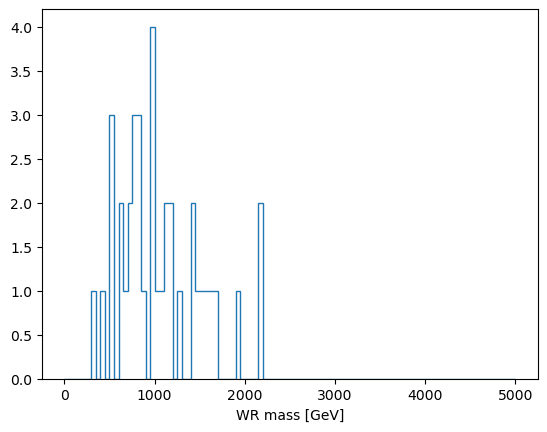

In [ ]:
plt.hist(ak.flatten(res["WRmass"]), bins=100, range=(0, 5000), histtype='step', label='WR mass')



### Signal 5049


In [ ]:
data = iter_allfile(signal5049)
signal5049eff = xsec5049*data[13]/data[11]*300

Processing ROOT files: 100%|██████████| 80/80 [02:19<00:00,  1.74s/it]


signal efficiency :  0.0015204245025211038
hlt efficiency :  0.0013203686469262217
 # of Signal event :  1.3610360012515493e-06


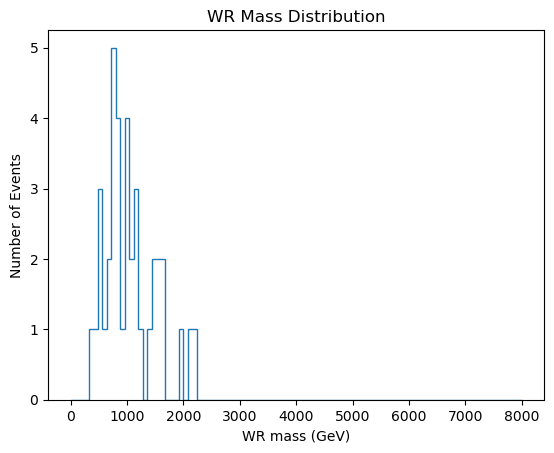

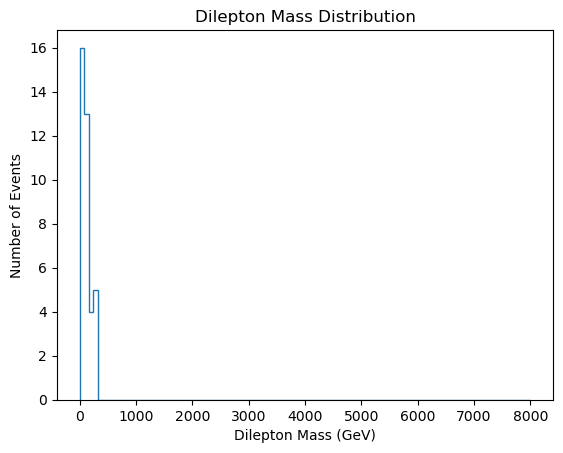

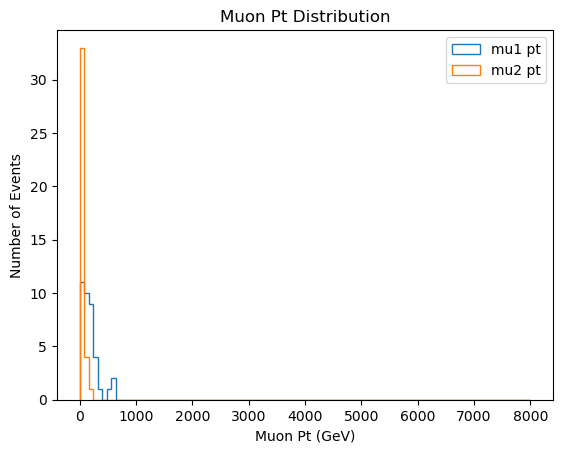

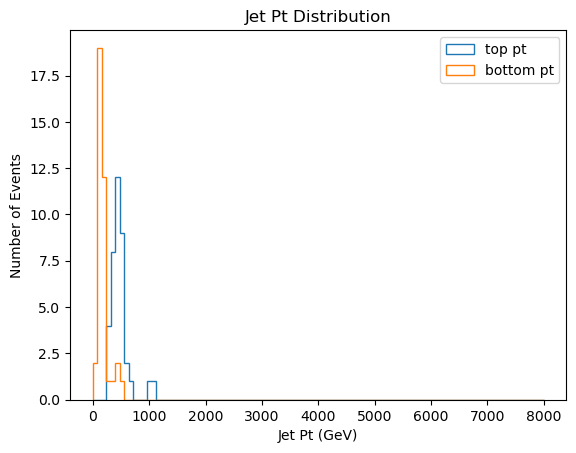

In [40]:
print("signal efficiency : ", data[12]/data[11]*100)
print("hlt efficiency : ", data[13]/data[11]*100)
print (" # of Signal event : ", xsec5049*data[13]/data[11]*300)
plt.hist(ak.flatten(data[0]), bins=100, range=(0, 8000), histtype='step', label='Combined P4')
plt.xlabel('WR mass (GeV)')
plt.ylabel('Number of Events')
plt.title('WR Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[1]), bins=100, range=(0, 8000), histtype='step', label='mll')
plt.xlabel('Dilepton Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('Dilepton Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[2]), bins=100, range=(0, 8000), histtype='step', label='mu1 pt')
plt.hist(ak.flatten(data[3]), bins=100, range=(0, 8000), histtype='step', label='mu2 pt')
plt.xlabel('Muon Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Muon Pt Distribution')
plt.legend()
plt.show()
plt.hist(ak.flatten(data[4]), bins=100, range=(0, 8000), histtype='step', label='top pt')
plt.hist(ak.flatten(data[5]), bins=100, range=(0, 8000), histtype='step', label='bottom pt')
plt.xlabel('Jet Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Jet Pt Distribution')
plt.legend()
plt.show()


### Signal 5041

In [22]:
data = iter_allfile(signal5041)

Processing ROOT files: 100%|██████████| 73/73 [02:10<00:00,  1.78s/it]


signal efficiency :  15.197260273972601
hlt efficiency :  14.95068493150685
 # of Signal event :  0.3724963150684932


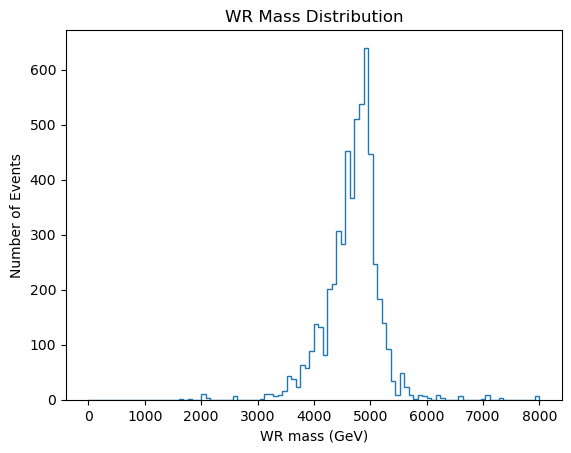

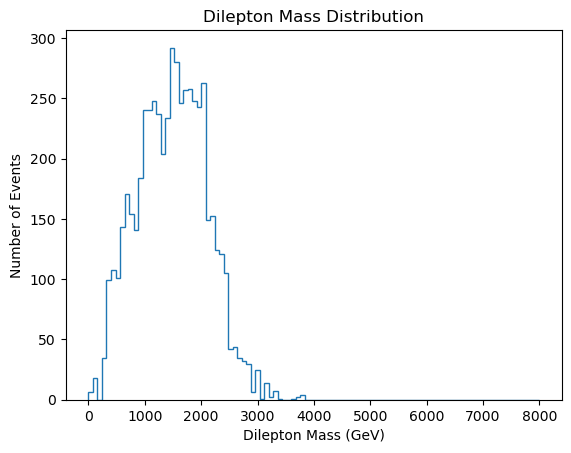

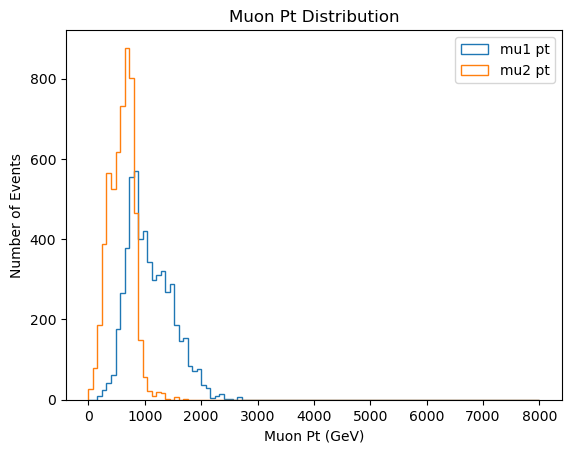

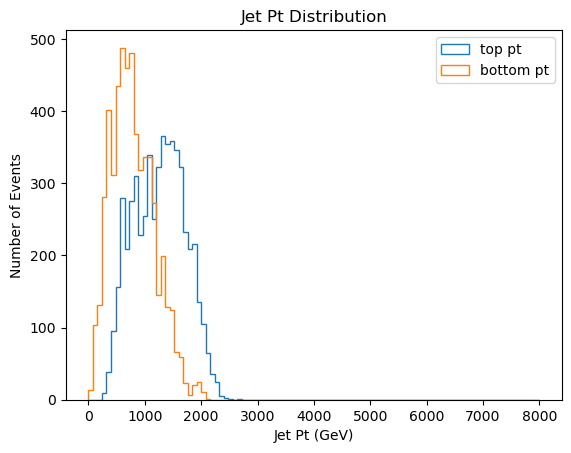

In [23]:
print("signal efficiency : ", data[12]/data[11]*100)
print("hlt efficiency : ", data[13]/data[11]*100)
print (" # of Signal event : ", xsec5041*data[13]/data[11]*300)
plt.hist(ak.flatten(data[0]), bins=100, range=(0, 8000), histtype='step', label='Combined P4')
plt.xlabel('WR mass (GeV)')
plt.ylabel('Number of Events')
plt.title('WR Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[1]), bins=100, range=(0, 8000), histtype='step', label='mll')
plt.xlabel('Dilepton Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('Dilepton Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[2]), bins=100, range=(0, 8000), histtype='step', label='mu1 pt')
plt.hist(ak.flatten(data[3]), bins=100, range=(0, 8000), histtype='step', label='mu2 pt')
plt.xlabel('Muon Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Muon Pt Distribution')
plt.legend()
plt.show()
plt.hist(ak.flatten(data[4]), bins=100, range=(0, 8000), histtype='step', label='top pt')
plt.hist(ak.flatten(data[5]), bins=100, range=(0, 8000), histtype='step', label='bottom pt')
plt.xlabel('Jet Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Jet Pt Distribution')
plt.legend()
plt.show()

### Signal 5033

In [24]:
data = iter_allfile(signal5033)

Processing ROOT files: 100%|██████████| 88/88 [02:25<00:00,  1.65s/it]


signal efficiency :  17.549999999999997
hlt efficiency :  17.179545454545455
 # of Signal event :  1.1420961818181818


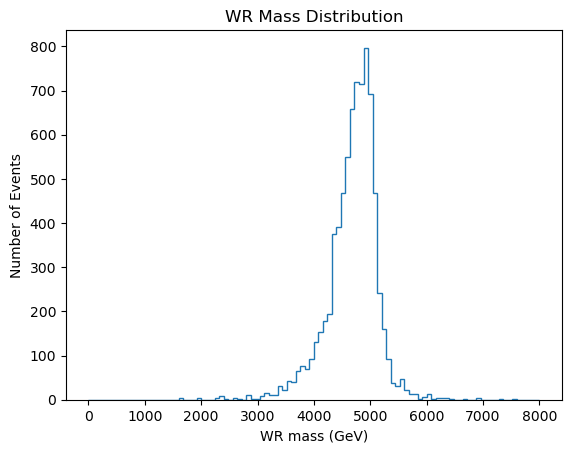

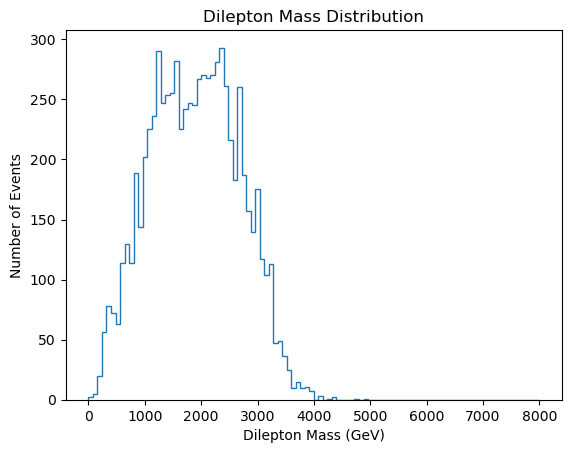

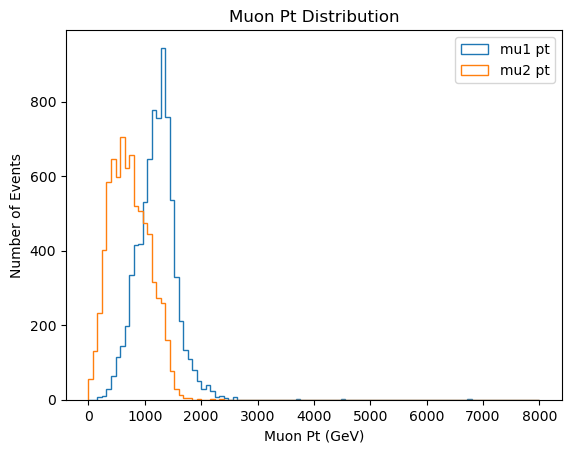

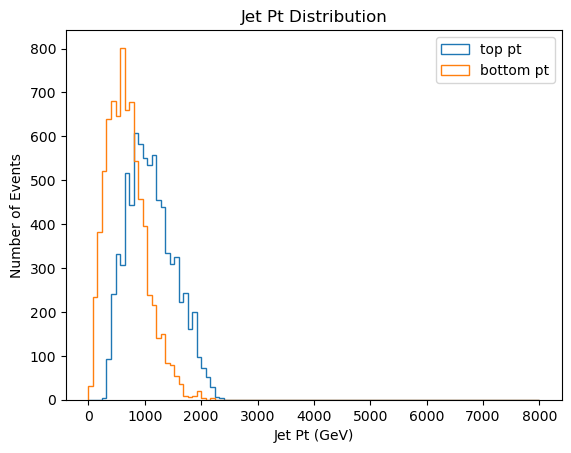

In [25]:
print("signal efficiency : ", data[12]/data[11]*100)
print("hlt efficiency : ", data[13]/data[11]*100)
print (" # of Signal event : ", xsec5033*data[13]/data[11]*300)
plt.hist(ak.flatten(data[0]), bins=100, range=(0, 8000), histtype='step', label='Combined P4')
plt.xlabel('WR mass (GeV)')
plt.ylabel('Number of Events')
plt.title('WR Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[1]), bins=100, range=(0, 8000), histtype='step', label='mll')
plt.xlabel('Dilepton Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('Dilepton Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[2]), bins=100, range=(0, 8000), histtype='step', label='mu1 pt')
plt.hist(ak.flatten(data[3]), bins=100, range=(0, 8000), histtype='step', label='mu2 pt')
plt.xlabel('Muon Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Muon Pt Distribution')
plt.legend()
plt.show()
plt.hist(ak.flatten(data[4]), bins=100, range=(0, 8000), histtype='step', label='top pt')
plt.hist(ak.flatten(data[5]), bins=100, range=(0, 8000), histtype='step', label='bottom pt')
plt.xlabel('Jet Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Jet Pt Distribution')
plt.legend()
plt.show()

### Signal 5025

In [18]:
data = iter_allfile(signal5025)

Processing ROOT files: 100%|██████████| 114/114 [02:59<00:00,  1.57s/it]


signal efficiency :  16.975438596491227
hlt efficiency :  16.682456140350876
 # of Signal event :  1.8012047894736842


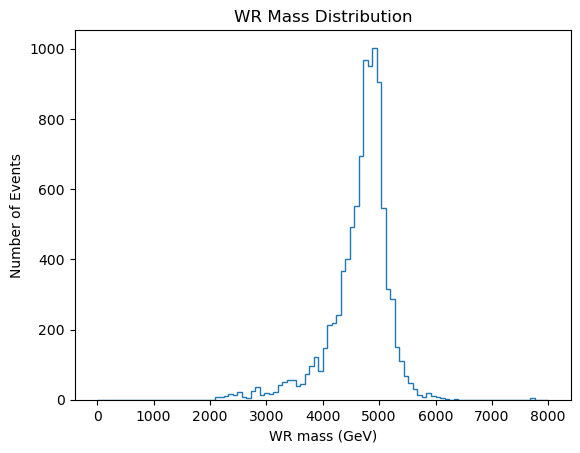

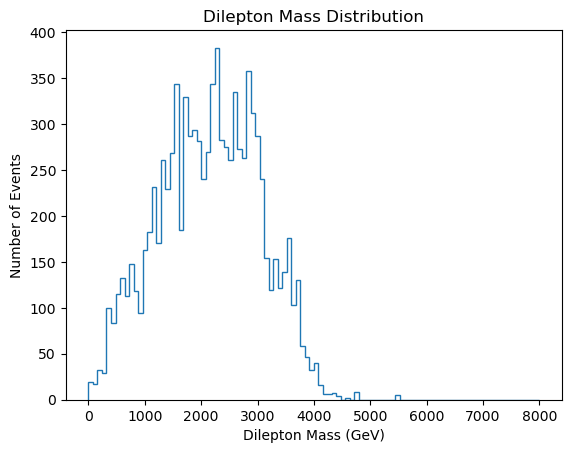

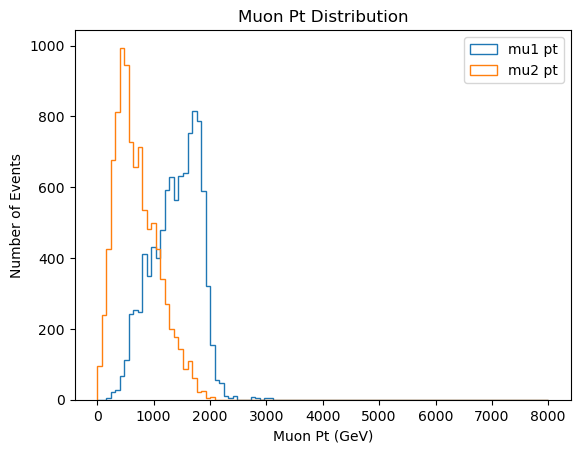

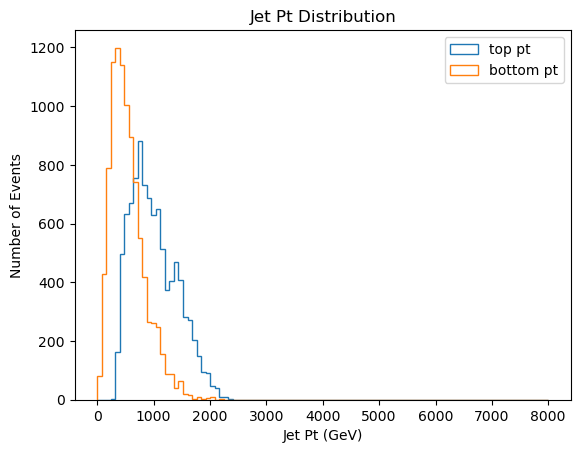

In [19]:
print("signal efficiency : ", data[12]/data[11]*100)
print("hlt efficiency : ", data[13]/data[11]*100)
print (" # of Signal event : ", xsec5025*data[13]/data[11]*300)
plt.hist(ak.flatten(data[0]), bins=100, range=(0, 8000), histtype='step', label='Combined P4')
plt.xlabel('WR mass (GeV)')
plt.ylabel('Number of Events')
plt.title('WR Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[1]), bins=100, range=(0, 8000), histtype='step', label='mll')
plt.xlabel('Dilepton Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('Dilepton Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[2]), bins=100, range=(0, 8000), histtype='step', label='mu1 pt')
plt.hist(ak.flatten(data[3]), bins=100, range=(0, 8000), histtype='step', label='mu2 pt')
plt.xlabel('Muon Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Muon Pt Distribution')
plt.legend()
plt.show()
plt.hist(ak.flatten(data[4]), bins=100, range=(0, 8000), histtype='step', label='top pt')
plt.hist(ak.flatten(data[5]), bins=100, range=(0, 8000), histtype='step', label='bottom pt')
plt.xlabel('Jet Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Jet Pt Distribution')
plt.legend()
plt.show()

### Signal 3029

In [20]:
data = iter_allfile(signal3029)

Processing ROOT files: 100%|██████████| 120/120 [03:52<00:00,  1.94s/it]


signal efficiency :  14.646666666666667
hlt efficiency :  14.305000000000001
 # of Signal event :  1.2797253


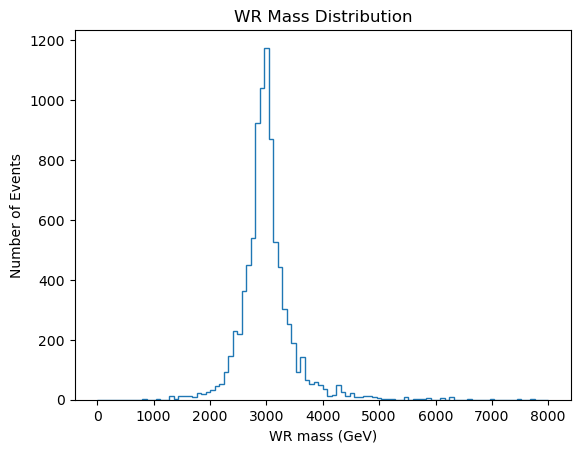

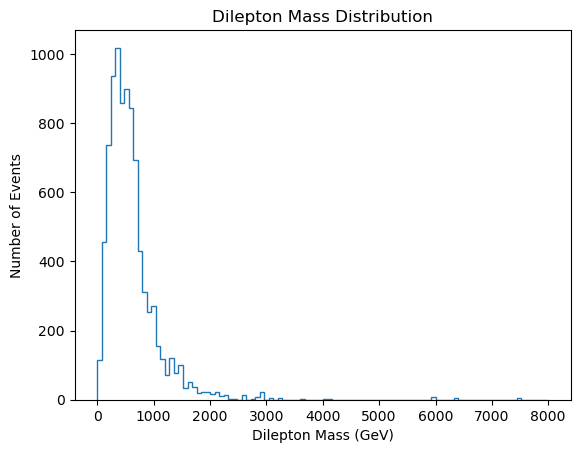

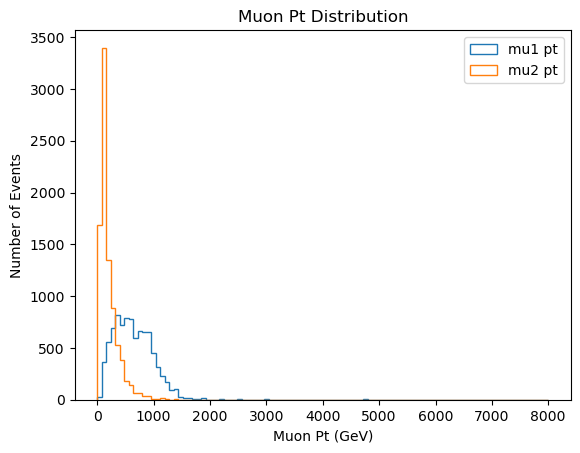

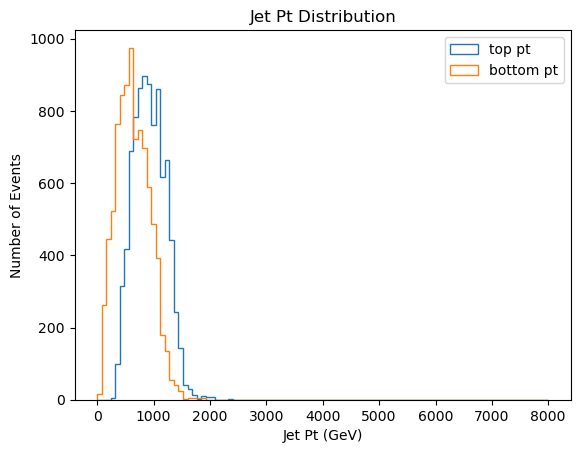

In [21]:
print("signal efficiency : ", data[12]/data[11]*100)
print("hlt efficiency : ", data[13]/data[11]*100)
print (" # of Signal event : ", xsec3029*data[13]/data[11]*300)
plt.hist(ak.flatten(data[0]), bins=100, range=(0, 8000), histtype='step', label='Combined P4')
plt.xlabel('WR mass (GeV)')
plt.ylabel('Number of Events')
plt.title('WR Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[1]), bins=100, range=(0, 8000), histtype='step', label='mll')
plt.xlabel('Dilepton Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('Dilepton Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[2]), bins=100, range=(0, 8000), histtype='step', label='mu1 pt')
plt.hist(ak.flatten(data[3]), bins=100, range=(0, 8000), histtype='step', label='mu2 pt')
plt.xlabel('Muon Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Muon Pt Distribution')
plt.legend()
plt.show()
plt.hist(ak.flatten(data[4]), bins=100, range=(0, 8000), histtype='step', label='top pt')
plt.hist(ak.flatten(data[5]), bins=100, range=(0, 8000), histtype='step', label='bottom pt')
plt.xlabel('Jet Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Jet Pt Distribution')
plt.legend()
plt.show()

### Signal 3021

In [26]:
data = iter_allfile(signal3021)

Processing ROOT files: 100%|██████████| 118/118 [03:39<00:00,  1.86s/it]


signal efficiency :  18.577966101694916
hlt efficiency :  18.291525423728814
 # of Signal event :  49.870014915254245


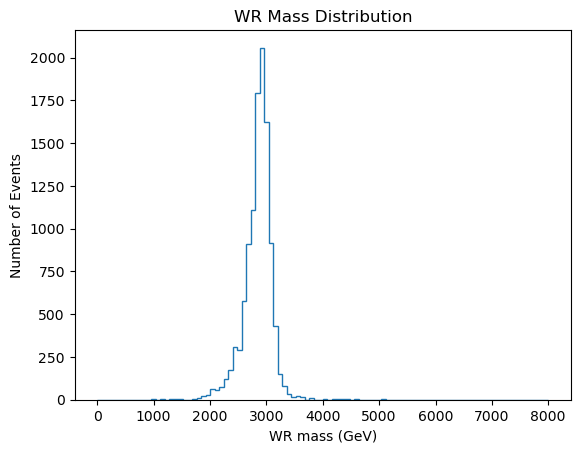

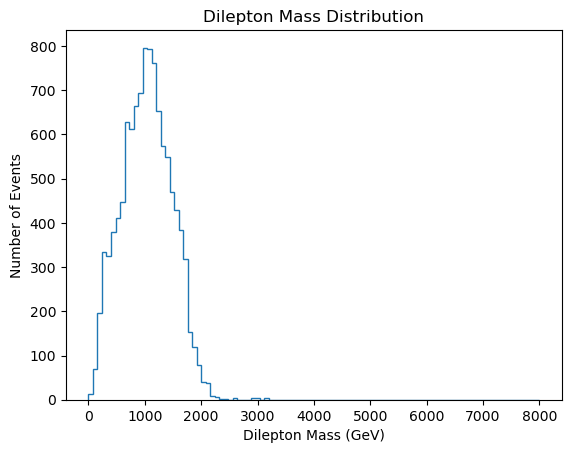

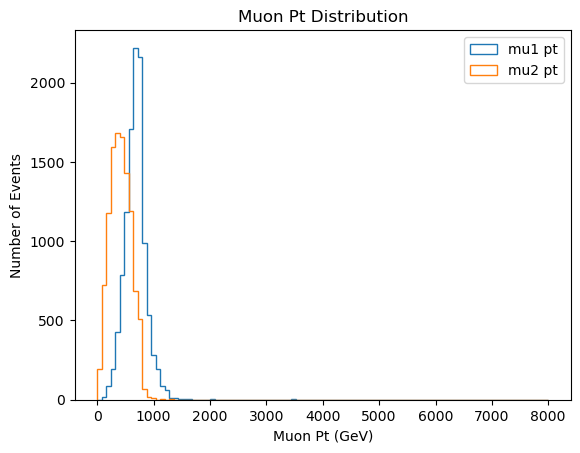

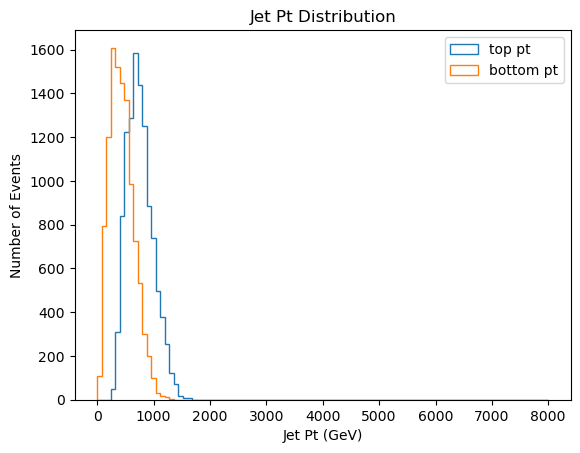

In [27]:
print("signal efficiency : ", data[12]/data[11]*100)
print("hlt efficiency : ", data[13]/data[11]*100)
print (" # of Signal event : ", xsec3021*data[13]/data[11]*300)
plt.hist(ak.flatten(data[0]), bins=100, range=(0, 8000), histtype='step', label='Combined P4')
plt.xlabel('WR mass (GeV)')
plt.ylabel('Number of Events')
plt.title('WR Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[1]), bins=100, range=(0, 8000), histtype='step', label='mll')
plt.xlabel('Dilepton Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('Dilepton Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[2]), bins=100, range=(0, 8000), histtype='step', label='mu1 pt')
plt.hist(ak.flatten(data[3]), bins=100, range=(0, 8000), histtype='step', label='mu2 pt')
plt.xlabel('Muon Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Muon Pt Distribution')
plt.legend()
plt.show()
plt.hist(ak.flatten(data[4]), bins=100, range=(0, 8000), histtype='step', label='top pt')
plt.hist(ak.flatten(data[5]), bins=100, range=(0, 8000), histtype='step', label='bottom pt')
plt.xlabel('Jet Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Jet Pt Distribution')
plt.legend()
plt.show()

### Signal 3013

In [28]:
data = iter_allfile(signal3013)

Processing ROOT files: 100%|██████████| 111/111 [03:38<00:00,  1.97s/it]


signal efficiency :  12.266666666666666
hlt efficiency :  12.061261261261262
 # of Signal event :  66.0715891891892


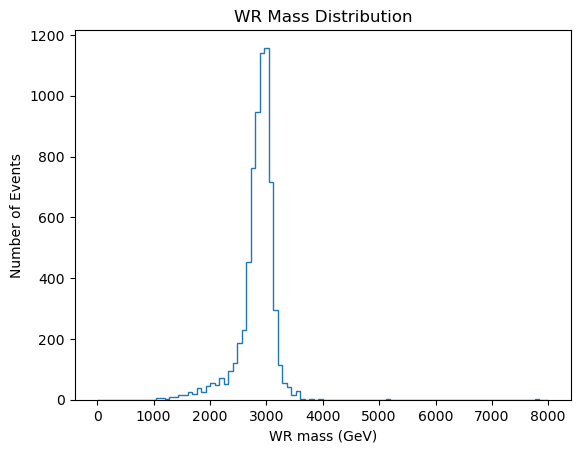

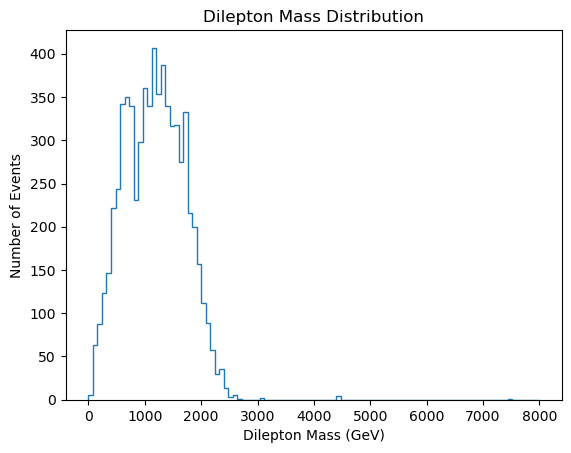

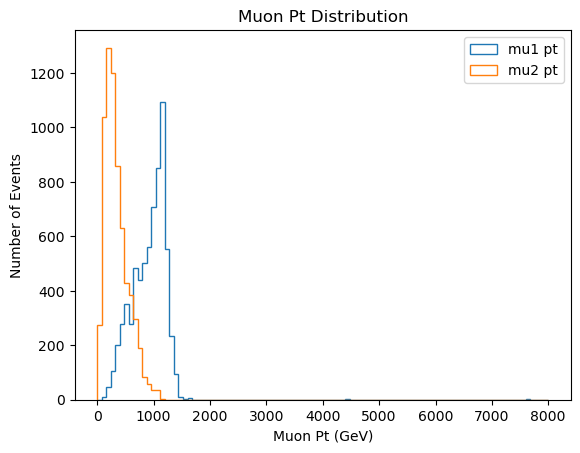

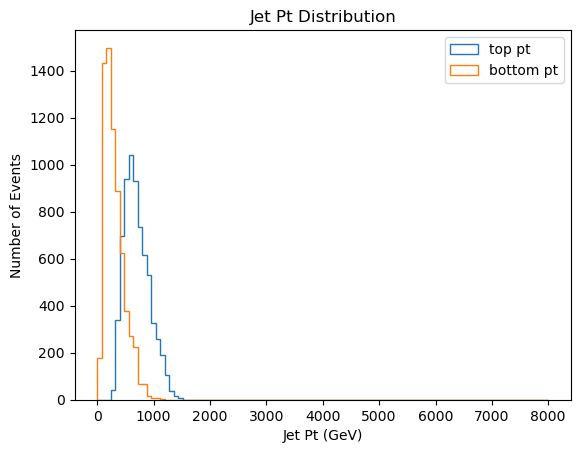

In [30]:
print("signal efficiency : ", data[12]/data[11]*100)
print("hlt efficiency : ", data[13]/data[11]*100)
print (" # of Signal event : ", xsec3013*data[13]/data[11]*300)
plt.hist(ak.flatten(data[0]), bins=100, range=(0, 8000), histtype='step', label='Combined P4')
plt.xlabel('WR mass (GeV)')
plt.ylabel('Number of Events')
plt.title('WR Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[1]), bins=100, range=(0, 8000), histtype='step', label='mll')
plt.xlabel('Dilepton Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('Dilepton Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[2]), bins=100, range=(0, 8000), histtype='step', label='mu1 pt')
plt.hist(ak.flatten(data[3]), bins=100, range=(0, 8000), histtype='step', label='mu2 pt')
plt.xlabel('Muon Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Muon Pt Distribution')
plt.legend()
plt.show()
plt.hist(ak.flatten(data[4]), bins=100, range=(0, 8000), histtype='step', label='top pt')
plt.hist(ak.flatten(data[5]), bins=100, range=(0, 8000), histtype='step', label='bottom pt')
plt.xlabel('Jet Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Jet Pt Distribution')
plt.legend()
plt.show()

### Signal 1070

In [39]:
data = iter_allfile(signal1070)

Processing ROOT files: 100%|██████████| 101/101 [03:09<00:00,  1.87s/it]


signal efficiency :  0.9326732673267326
hlt efficiency :  0.8990099009900989
 # of Signal event :  524.8419801980198


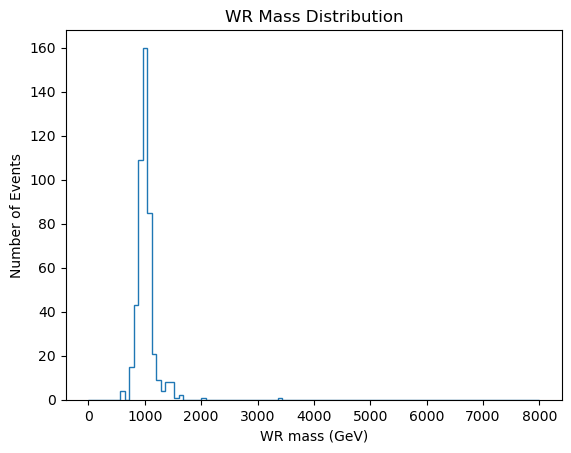

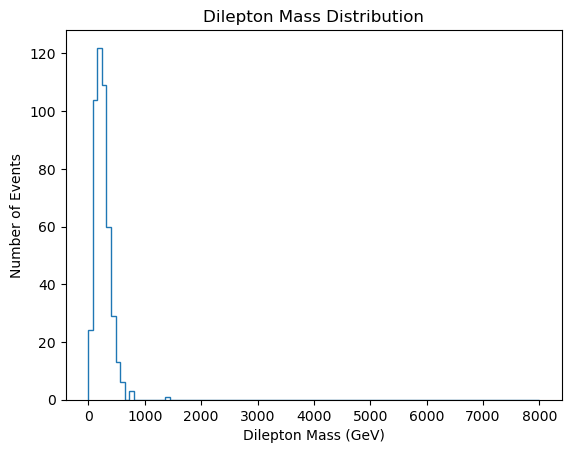

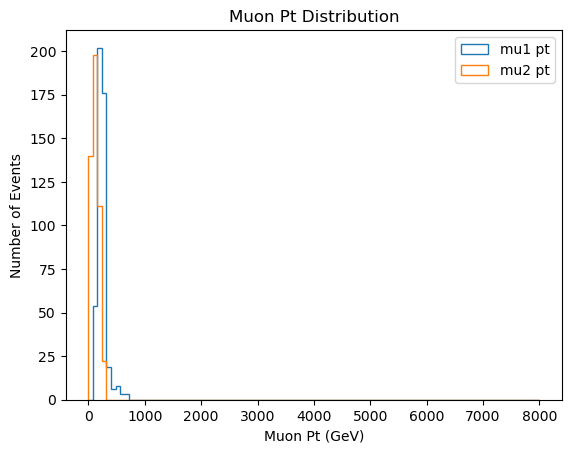

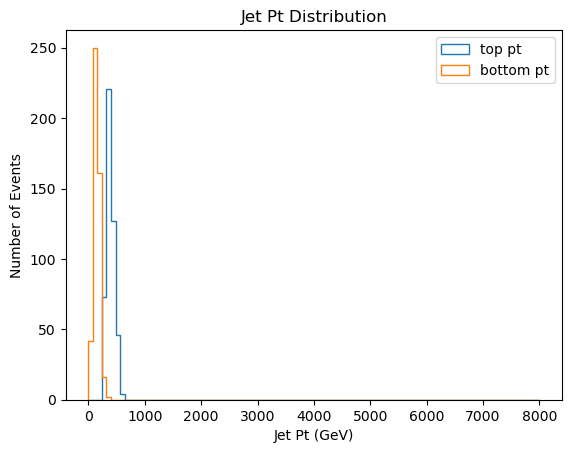

In [40]:
print("signal efficiency : ", data[12]/data[11]*100)
print("hlt efficiency : ", data[13]/data[11]*100)
print (" # of Signal event : ", xsec1070*data[13]/data[11]*300)
plt.hist(ak.flatten(data[0]), bins=100, range=(0, 8000), histtype='step', label='Combined P4')
plt.xlabel('WR mass (GeV)')
plt.ylabel('Number of Events')
plt.title('WR Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[1]), bins=100, range=(0, 8000), histtype='step', label='mll')
plt.xlabel('Dilepton Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('Dilepton Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[2]), bins=100, range=(0, 8000), histtype='step', label='mu1 pt')
plt.hist(ak.flatten(data[3]), bins=100, range=(0, 8000), histtype='step', label='mu2 pt')
plt.xlabel('Muon Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Muon Pt Distribution')
plt.legend()
plt.show()
plt.hist(ak.flatten(data[4]), bins=100, range=(0, 8000), histtype='step', label='top pt')
plt.hist(ak.flatten(data[5]), bins=100, range=(0, 8000), histtype='step', label='bottom pt')
plt.xlabel('Jet Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Jet Pt Distribution')
plt.legend()
plt.show()

### TW(twm_2l2nu)

In [4]:
data = iter_allfile(twm_2l2nu_all)

Processing ROOT files: 100%|██████████| 73/73 [05:12<00:00,  4.29s/it]


signal efficiency :  0.0018277860028147906
hlt efficiency :  0.0015028462689810498
 # of Signal event :  371.05274381142124


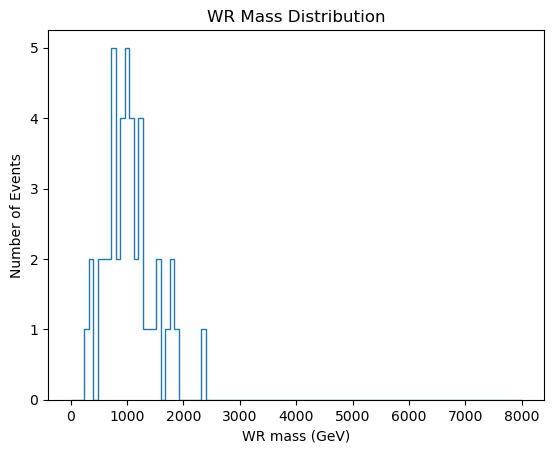

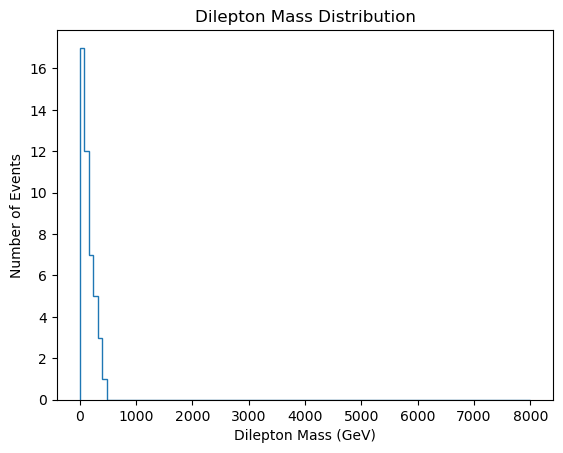

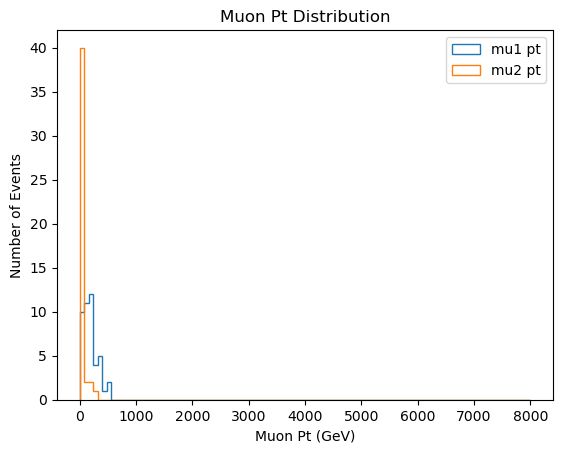

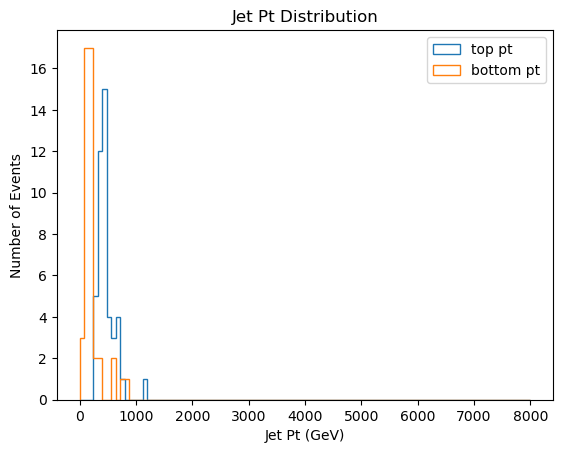

In [8]:
print("signal efficiency : ", data[12]/data[11]*100)
print("hlt efficiency : ", data[13]/data[11]*100)
print (" # of Signal event : ", xsec_twm_2l2nu *data[13]/data[11]*300)
plt.hist(ak.flatten(data[0]), bins=100, range=(0, 8000), histtype='step', label='Combined P4')
plt.xlabel('WR mass (GeV)')
plt.ylabel('Number of Events')
plt.title('WR Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[1]), bins=100, range=(0, 8000), histtype='step', label='mll')
plt.xlabel('Dilepton Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('Dilepton Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[2]), bins=100, range=(0, 8000), histtype='step', label='mu1 pt')
plt.hist(ak.flatten(data[3]), bins=100, range=(0, 8000), histtype='step', label='mu2 pt')
plt.xlabel('Muon Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Muon Pt Distribution')
plt.legend()
plt.show()
plt.hist(ak.flatten(data[4]), bins=100, range=(0, 8000), histtype='step', label='top pt')
plt.hist(ak.flatten(data[5]), bins=100, range=(0, 8000), histtype='step', label='bottom pt')
plt.xlabel('Jet Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Jet Pt Distribution')
plt.legend()
plt.show()

### TW(twp_2l2nu)

In [9]:
data = iter_allfile(twp_2l2nu_all)

Processing ROOT files: 100%|██████████| 56/56 [04:31<00:00,  4.84s/it]


signal efficiency :  0.0015204245025211038
hlt efficiency :  0.0013203686469262217
 # of Signal event :  325.99901892608415


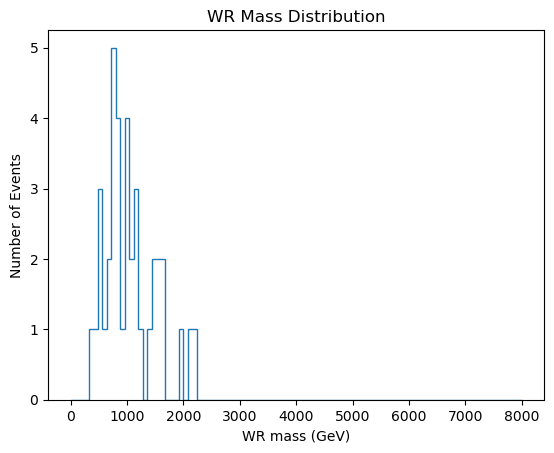

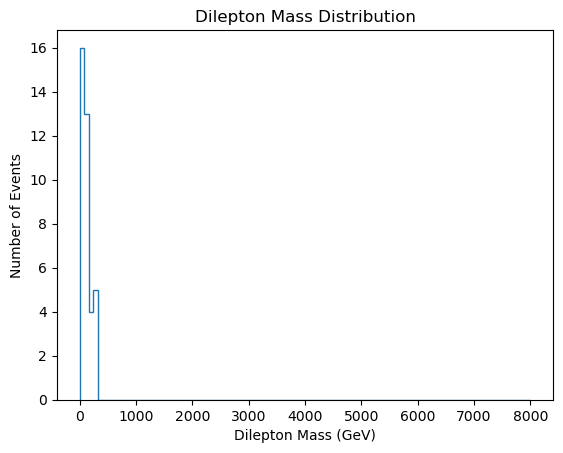

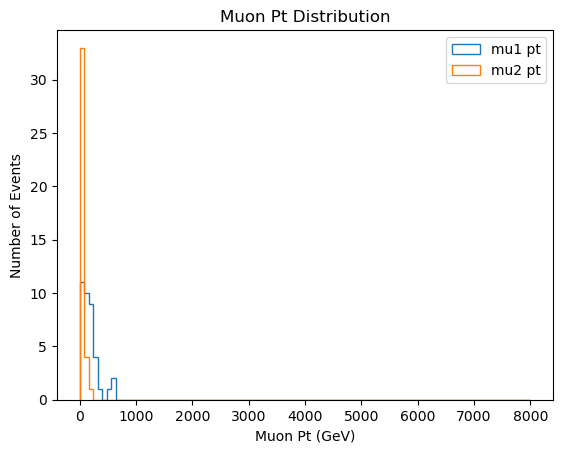

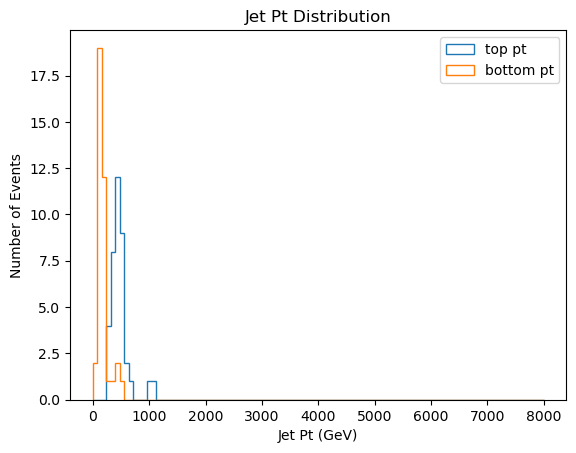

In [10]:
print("signal efficiency : ", data[12]/data[11]*100)
print("hlt efficiency : ", data[13]/data[11]*100)
print (" # of Signal event : ", xsec_twp_2l2nu *data[13]/data[11]*300)
plt.hist(ak.flatten(data[0]), bins=100, range=(0, 8000), histtype='step', label='Combined P4')
plt.xlabel('WR mass (GeV)')
plt.ylabel('Number of Events')
plt.title('WR Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[1]), bins=100, range=(0, 8000), histtype='step', label='mll')
plt.xlabel('Dilepton Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('Dilepton Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[2]), bins=100, range=(0, 8000), histtype='step', label='mu1 pt')
plt.hist(ak.flatten(data[3]), bins=100, range=(0, 8000), histtype='step', label='mu2 pt')
plt.xlabel('Muon Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Muon Pt Distribution')
plt.legend()
plt.show()
plt.hist(ak.flatten(data[4]), bins=100, range=(0, 8000), histtype='step', label='top pt')
plt.hist(ak.flatten(data[5]), bins=100, range=(0, 8000), histtype='step', label='bottom pt')
plt.xlabel('Jet Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Jet Pt Distribution')
plt.legend()
plt.show()

### TW (tw_lnu2q)

In [11]:
data = iter_allfile(twp_2l2nu_all)

Processing ROOT files:   0%|          | 0/56 [00:00<?, ?it/s]

Processing ROOT files: 100%|██████████| 56/56 [03:33<00:00,  3.82s/it]


signal efficiency :  0.0015204245025211038
hlt efficiency :  0.0013203686469262217
 # of Signal event :  325.99901892608415


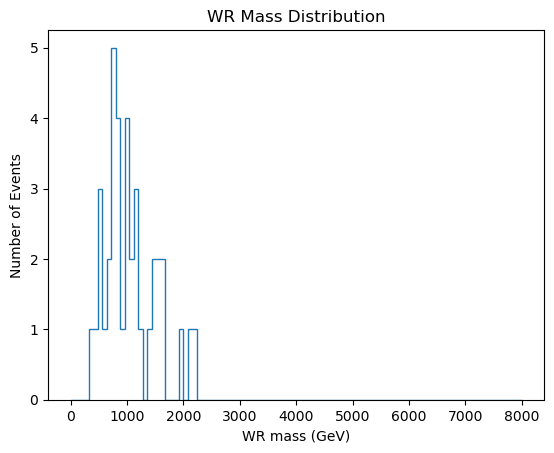

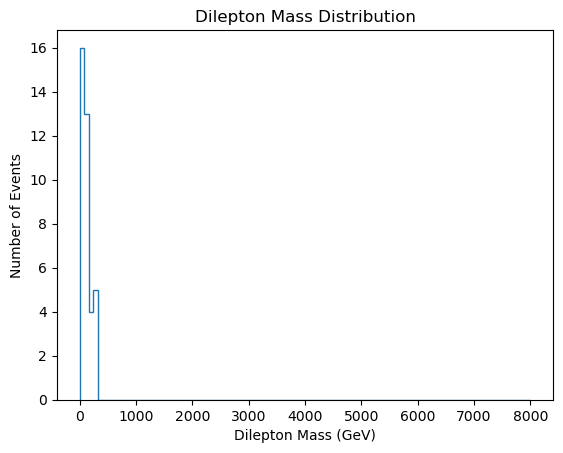

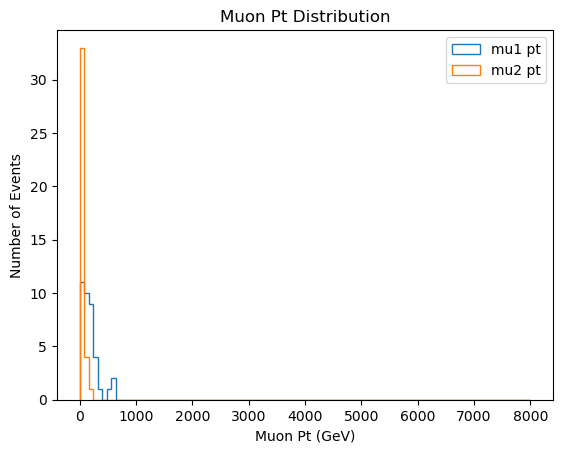

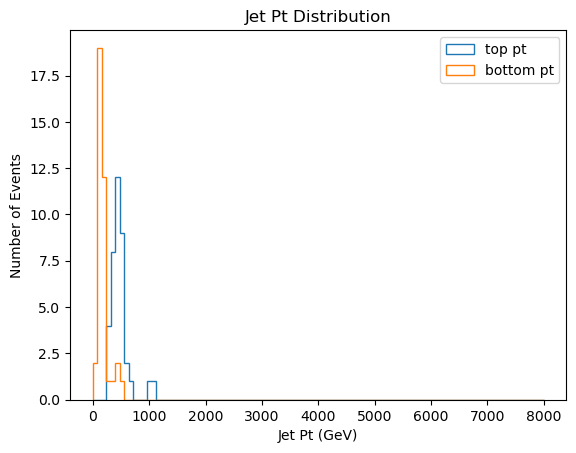

In [12]:
print("signal efficiency : ", data[12]/data[11]*100)
print("hlt efficiency : ", data[13]/data[11]*100)
print (" # of Signal event : ", xsec_tw_lnu2q *data[13]/data[11]*300)
plt.hist(ak.flatten(data[0]), bins=100, range=(0, 8000), histtype='step', label='Combined P4')
plt.xlabel('WR mass (GeV)')
plt.ylabel('Number of Events')
plt.title('WR Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[1]), bins=100, range=(0, 8000), histtype='step', label='mll')
plt.xlabel('Dilepton Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('Dilepton Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[2]), bins=100, range=(0, 8000), histtype='step', label='mu1 pt')
plt.hist(ak.flatten(data[3]), bins=100, range=(0, 8000), histtype='step', label='mu2 pt')
plt.xlabel('Muon Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Muon Pt Distribution')
plt.legend()
plt.show()
plt.hist(ak.flatten(data[4]), bins=100, range=(0, 8000), histtype='step', label='top pt')
plt.hist(ak.flatten(data[5]), bins=100, range=(0, 8000), histtype='step', label='bottom pt')
plt.xlabel('Jet Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Jet Pt Distribution')
plt.legend()
plt.show()

### TTH(tth_mumu)

In [13]:
data = iter_allfile(twp_2l2nu_all)

Processing ROOT files:   0%|          | 0/56 [00:00<?, ?it/s]

Processing ROOT files: 100%|██████████| 56/56 [03:38<00:00,  3.91s/it]


signal efficiency :  0.0015204245025211038
hlt efficiency :  0.0013203686469262217
 # of Signal event :  1.9805529703893328


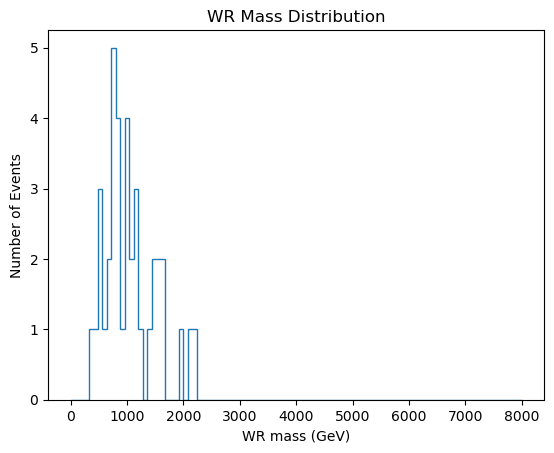

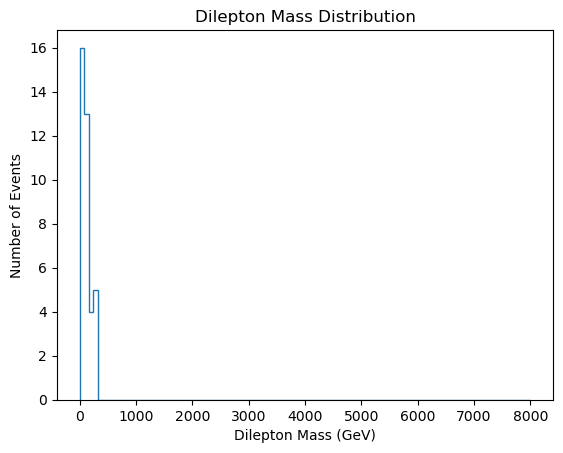

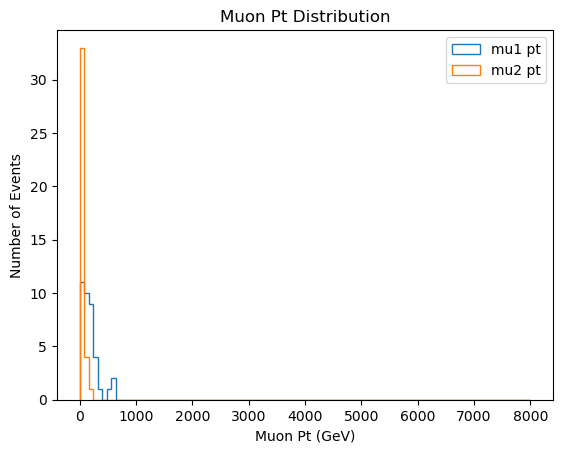

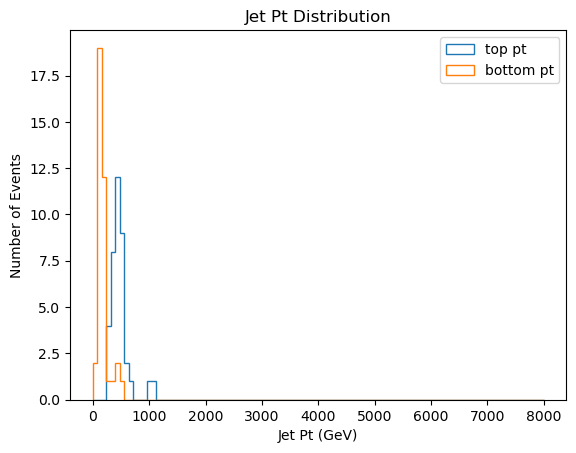

In [14]:
print("signal efficiency : ", data[12]/data[11]*100)
print("hlt efficiency : ", data[13]/data[11]*100)
print (" # of Signal event : ", xsec_tth_mumu *data[13]/data[11]*300)
plt.hist(ak.flatten(data[0]), bins=100, range=(0, 8000), histtype='step', label='Combined P4')
plt.xlabel('WR mass (GeV)')
plt.ylabel('Number of Events')
plt.title('WR Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[1]), bins=100, range=(0, 8000), histtype='step', label='mll')
plt.xlabel('Dilepton Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('Dilepton Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[2]), bins=100, range=(0, 8000), histtype='step', label='mu1 pt')
plt.hist(ak.flatten(data[3]), bins=100, range=(0, 8000), histtype='step', label='mu2 pt')
plt.xlabel('Muon Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Muon Pt Distribution')
plt.legend()
plt.show()
plt.hist(ak.flatten(data[4]), bins=100, range=(0, 8000), histtype='step', label='top pt')
plt.hist(ak.flatten(data[5]), bins=100, range=(0, 8000), histtype='step', label='bottom pt')
plt.xlabel('Jet Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Jet Pt Distribution')
plt.legend()
plt.show()

### TTH(tth_zz)

In [15]:
data = iter_allfile(twp_2l2nu_all)

Processing ROOT files: 100%|██████████| 56/56 [03:24<00:00,  3.65s/it]


signal efficiency :  0.0015204245025211038
hlt efficiency :  0.0013203686469262217
 # of Signal event :  1.9805529703893328


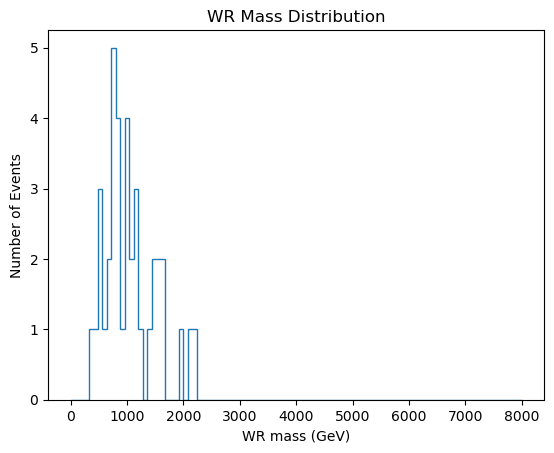

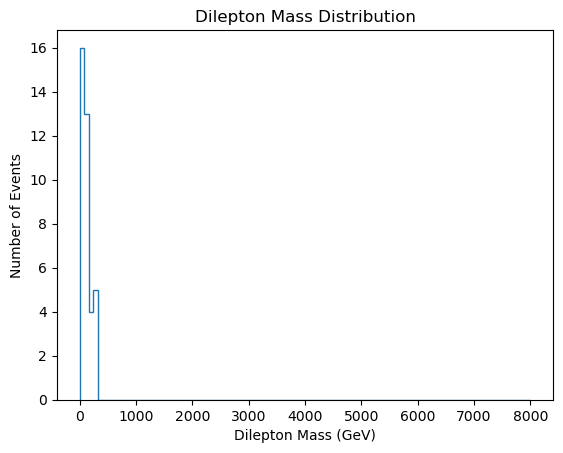

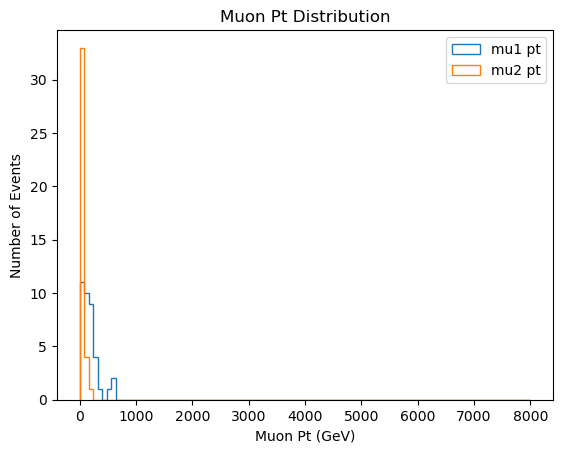

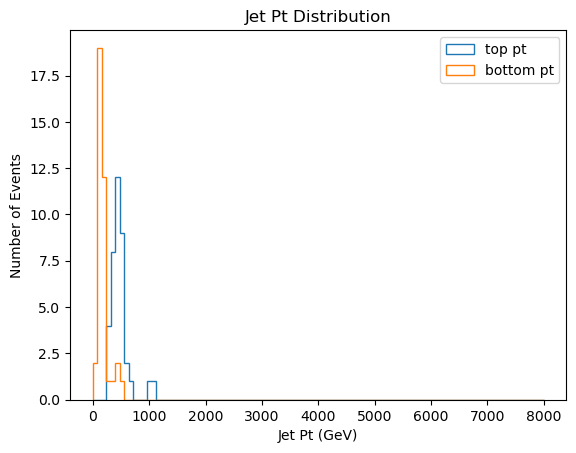

In [16]:
print("signal efficiency : ", data[12]/data[11]*100)
print("hlt efficiency : ", data[13]/data[11]*100)
print (" # of Signal event : ", xsec_tth_zz *data[13]/data[11]*300)
plt.hist(ak.flatten(data[0]), bins=100, range=(0, 8000), histtype='step', label='Combined P4')
plt.xlabel('WR mass (GeV)')
plt.ylabel('Number of Events')
plt.title('WR Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[1]), bins=100, range=(0, 8000), histtype='step', label='mll')
plt.xlabel('Dilepton Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('Dilepton Mass Distribution')
plt.show()
plt.hist(ak.flatten(data[2]), bins=100, range=(0, 8000), histtype='step', label='mu1 pt')
plt.hist(ak.flatten(data[3]), bins=100, range=(0, 8000), histtype='step', label='mu2 pt')
plt.xlabel('Muon Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Muon Pt Distribution')
plt.legend()
plt.show()
plt.hist(ak.flatten(data[4]), bins=100, range=(0, 8000), histtype='step', label='top pt')
plt.hist(ak.flatten(data[5]), bins=100, range=(0, 8000), histtype='step', label='bottom pt')
plt.xlabel('Jet Pt (GeV)')
plt.ylabel('Number of Events')
plt.title('Jet Pt Distribution')
plt.legend()
plt.show()

### TTZ(ttz_mumu)